# Logistic Regression Assignment

*Prafful Agrawal*  
*08/02/2021*

### Problem Statement

Build a logistic regression model using the **affairs dataset** from the *statsmodel* package to predict if the woman have atleast one affair or not.

### Solution

Let us import the required packages.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

Now, load the *Affairs Data* as a Pandas Dataframe.

In [2]:
from statsmodels.api import datasets
affairs_data = datasets.fair.load_pandas().data
affairs_data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


The description of the data is as given below:

In [3]:
print(datasets.fair.DESCRSHORT, datasets.fair.NOTE)

Extramarital affair data. ::

    Number of observations: 6366
    Number of variables: 9
    Variable name definitions:

        rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                        4 = good, 5 = very good
        age             : Age
        yrs_married     : No. years married. Interval approximations. See
                        original paper for detailed explanation.
        children        : No. children
        religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                        4 = strongly
        educ            : Level of education, 9 = grade school, 12 = high
                        school, 14 = some college, 16 = college graduate,
                        17 = some graduate school, 20 = advanced degree
        occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                        or unskilled worker; 3 = white-colloar; 4 = teacher
                        counselor social worker, nurse; a

There are 9 variables out of which 5 are categorical variables. Among the categorical variables, 3 are *ordinal* in nature (`rate_marriage`, `religious` and `educ`) while the remaining 2 are *nominal* in nature (`occupation` and `occupation_husb`). There are a total of 6366 observations.

Let us check for missing values.

In [4]:
affairs_data.isna().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
dtype: int64

It seems that there are no missing values in our data.

Let us look at the distribution of data:

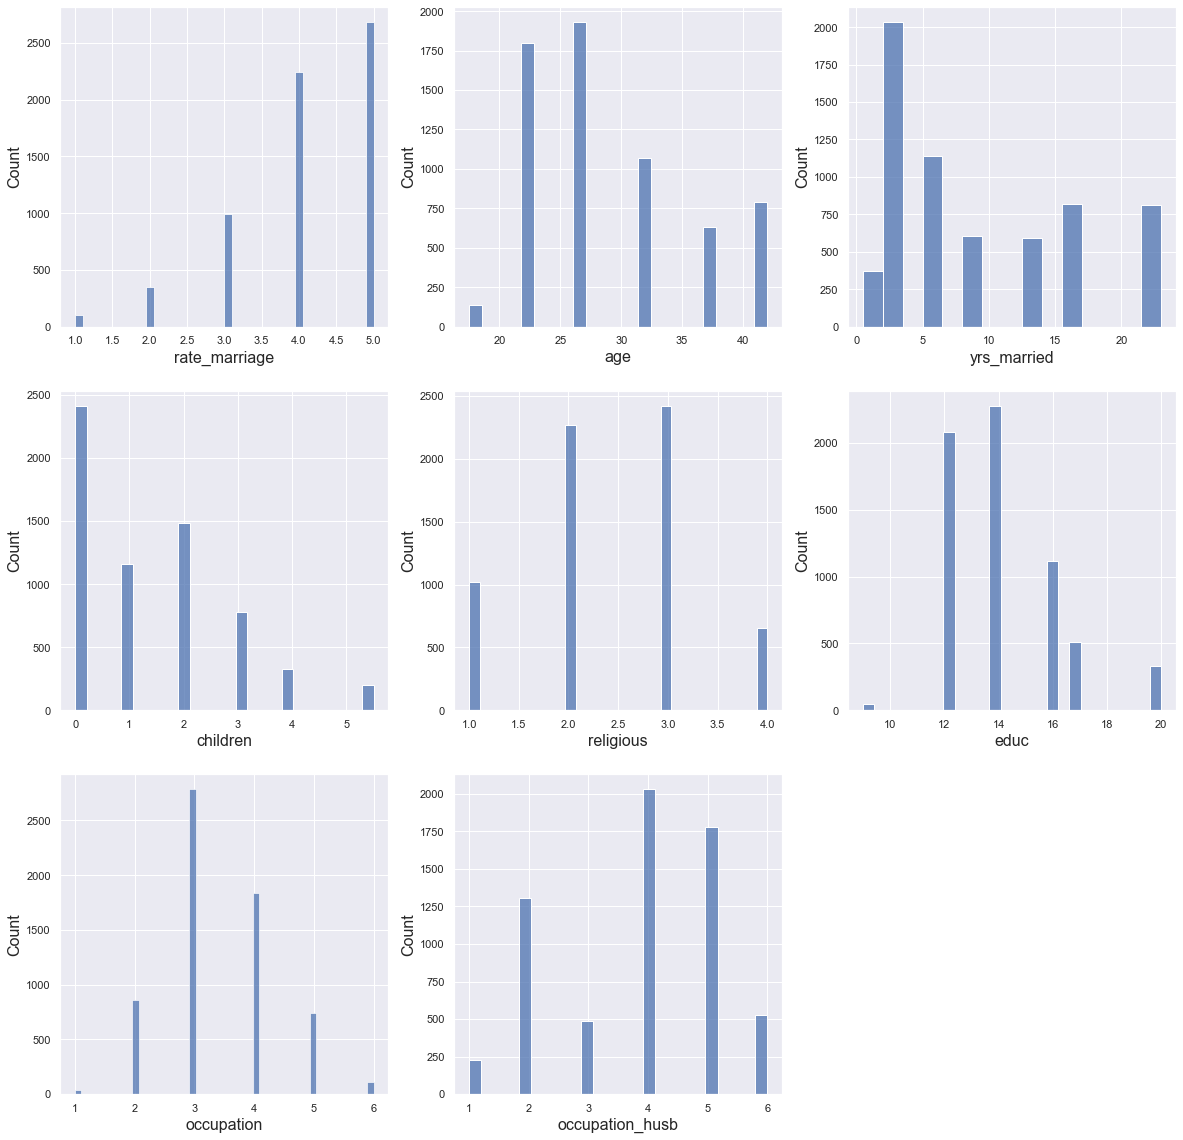

In [5]:
plt.figure(figsize = (20, 20))
plotnumber = 1
for column in affairs_data.columns[:-1]:
    ax = plt.subplot(3, 3, plotnumber)
    sns.histplot(data = affairs_data[column], stat = 'count')
    plt.xlabel(column, fontsize = 16)
    plt.ylabel('Count', fontsize = 16)
    plotnumber += 1
plt.show()

Here, we have discrete levels for each variable. This is true even for numerical variables. The levels are not spread out in any distinct pattern. 

Now, create a binary variable `if_affair` which indicates if a woman have had atleast one affair. It will be equal to `0` if NO time in affair. Otherwise, it will be `1` if any time in affair. This will be used as the target variable.

In [6]:
data = affairs_data.drop(columns = 'affairs')
# If any time in affair
data['if_affair'] = (affairs_data['affairs'] > 0).astype(int)
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,if_affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


Let us look at the relationship between the target and predictor variables.

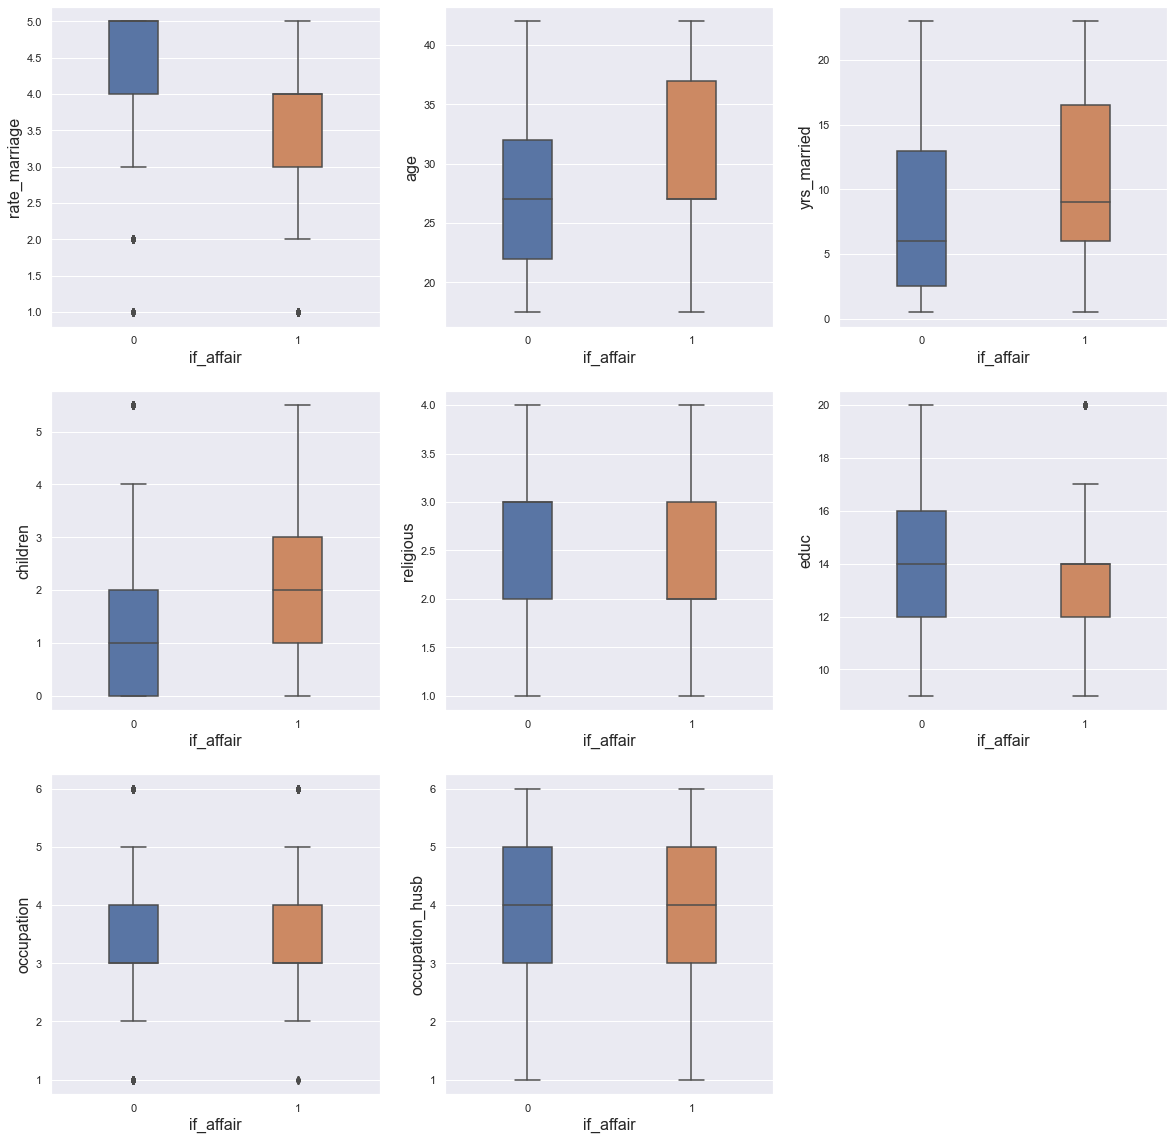

In [7]:
plt.figure(figsize = (20, 20))
plotnumber = 1
for column in data.columns[:-1]:
    ax = plt.subplot(3, 3, plotnumber)
    sns.boxplot(y = data[column], x = data['if_affair'], width = 0.3)
    plt.xlabel('if_affair', fontsize = 16)
    plt.ylabel(column, fontsize = 16)
    plotnumber += 1
plt.show()

Some of the variables show a relationship with the target variable and hence can be used for classification.

Now, check for multicollinearity between the independent variables. For this, we can either use the Variance Inflation Factor (VIF) or the Correlation Matrix. We will first calculate VIF.

In [8]:
scaler = StandardScaler()
variables = scaler.fit_transform(data.drop(columns = 'if_affair'))
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif["Features"] = data.columns[:-1]
vif

,VIF,Features
0,1.034798,rate_marriage
1,5.454116,age
2,7.142949,yrs_married
3,2.528972,children
4,1.036906,religious
5,1.296242,educ
6,1.206863,occupation
7,1.082876,occupation_husb


The 2 variables `age` and `yrs_married` have VIF above the threshold value of 5.

We proceed to construct the Correlation Matrix.

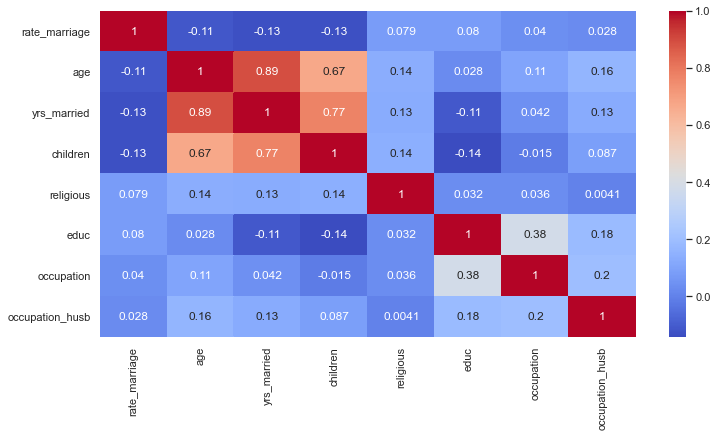

In [9]:
plt.figure(figsize = (12, 6))
sns.heatmap(data.drop(columns = 'if_affair').corr(), annot = True, cmap = 'coolwarm')
plt.show()

The correlation between the above two variables is also high (above 0.8). This *confirms* multicollinearity.

To remedy this, we drop the variable `age`.

In [10]:
data_new = data.drop(columns = 'age')
data_new.head()

,rate_marriage,yrs_married,children,religious,educ,occupation,occupation_husb,if_affair
0,3.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,9.0,1.0,1.0,14.0,3.0,4.0,1


Now, let us prepare the data for the model development.

For the predictor variables, we will one-hot encode the `occupation` and `occupation_husb` variables since they are nominal in nature. We will use the remaining categorical variables *as is* since they are ordinal in nature, i.e. their order represents a increase or decrease in quality.

In [11]:
X = data_new.drop(columns = ['occupation', 'occupation_husb', 'if_affair'])
# One-hot encode the 'occupation' column
one_hot_occ = pd.get_dummies(data_new['occupation'], prefix = 'occ', drop_first = True)
X = X.join(one_hot_occ)
# One-hot encode the 'occupation_husb' column
one_hot_occ_husb = pd.get_dummies(data_new['occupation_husb'], prefix = 'occ_husb', drop_first = True)
X = X.join(one_hot_occ_husb)
X.head()

,rate_marriage,yrs_married,children,religious,educ,occ_2.0,occ_3.0,occ_4.0,occ_5.0,occ_6.0,occ_husb_2.0,occ_husb_3.0,occ_husb_4.0,occ_husb_5.0,occ_husb_6.0
0,3.0,9.0,3.0,3.0,17.0,1,0,0,0,0,0,0,0,1,0
1,3.0,13.0,3.0,1.0,14.0,0,1,0,0,0,0,0,1,0,0
2,4.0,2.5,0.0,1.0,16.0,0,1,0,0,0,0,0,0,1,0
3,4.0,16.5,4.0,3.0,16.0,0,0,0,1,0,0,0,0,1,0
4,5.0,9.0,1.0,1.0,14.0,0,1,0,0,0,0,0,1,0,0


For the target variable, we will use the `if_affair` variable.

In [12]:
y = data_new['if_affair']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: if_affair, dtype: int32

Let us split the data into the training and testing set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

Fit a logistic regression model. We will use *L2* or *Ridge* regularization.

In [14]:
lr = LogisticRegression(penalty = 'l2', random_state = 123,  max_iter = 1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=123)

The model prediction on the test data is given as:

In [15]:
y_pred = lr.predict(X_test)

We can plot the confusion matrix as follows:

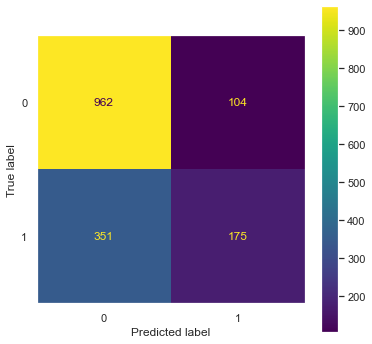

In [16]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.grid(None)
plot_confusion_matrix(lr, X_test, y_test, ax = ax)
plt.show()

Here, we have -

1. True Negative (TN) = 962
2. False Negative (FN) = 351
3. False Positive (FP) = 104
4. True Positive (TP) = 175

With this we can calculate various evaluation metrics.

The accuracy score of the model is given below:

In [17]:
# Accuracy score = (TP + TN)/(TP + FP + FN + TN)
lr.score(X_test, y_test)

0.7141959798994975

Similarly, we have the Precision, Recall and the F1 score as follows:

In [18]:
# Precision = TP / (TP + FP)
precision_score(y_test, y_pred)

0.6272401433691757

In [19]:
# Recall = TP / (TP + FN)
recall_score(y_test, y_pred)

0.33269961977186313

In [20]:
# F1 score = 2 * (Precision * Recall) / (Precision + Recall)
f1_score(y_test, y_pred)

0.43478260869565216

Now, we can also calculate the area under the curve of a ROC curve as given below:

In [21]:
auc = roc_auc_score(y_test, y_pred)
auc

0.6175693220810535

This is shown on a ROC curve as follows:

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

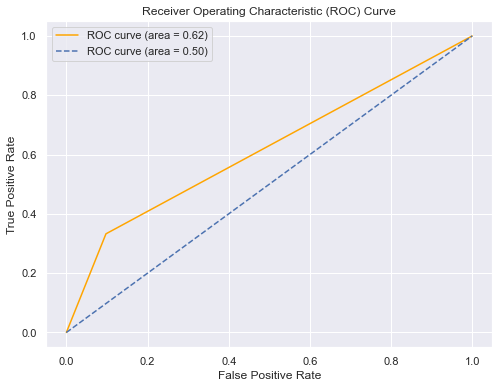

In [23]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.plot(fpr, tpr, color = 'orange', label = 'ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'ROC curve (area = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Hence, we have successfully developed a logistic regression classification model.